In [ ]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

Using User-Defined Triton Kernels with `torch.compile`
======================================================

**Author:** [Oguz Ulgen](https://github.com/oulgen)


User-defined Triton kernels can be used to optimize specific parts of
your model\'s computation. These kernels are written in Triton\'s
language, which is designed to make it easier to achieve peak hardware
performance. By using user-defined Triton kernels with `torch.compile`,
you can integrate these optimized computations into your PyTorch model,
potentially achieving significant performance improvements.

This recipes demonstrates how you can use user-defined Triton kernels
with `torch.compile`.

Prerequisites
=============

Before starting this recipe, make sure that you have the following:

-   Basic understanding of `torch.compile` and Triton. See:
    -   [torch.compiler API
        documentation](https://pytorch.org/docs/stable/torch.compiler.html#torch-compiler)
    -   [Introduction to
        torch.compile](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html)
    -   [Triton language
        documentation](https://triton-lang.org/main/index.html)
-   PyTorch 2.3 or later
-   A GPU that supports Triton


In [1]:
import torch
from torch.utils._triton import has_triton

Basic Usage
===========

In this example, we will use a simple vector addition kernel from the
Triton documentation with `torch.compile`. For reference, see [Triton
documentation](https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html).


In [2]:
if not has_triton():
    print("Skipping because triton is not supported on this device.")
else:
    import triton
    from triton import language as tl

    @triton.jit
    def add_kernel(
        in_ptr0,
        in_ptr1,
        out_ptr,
        n_elements,
        BLOCK_SIZE: "tl.constexpr",
    ):
        pid = tl.program_id(axis=0)
        block_start = pid * BLOCK_SIZE
        offsets = block_start + tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_elements
        x = tl.load(in_ptr0 + offsets, mask=mask)
        y = tl.load(in_ptr1 + offsets, mask=mask)
        output = x + y
        tl.store(out_ptr + offsets, output, mask=mask)

    @torch.compile(fullgraph=True)
    def add_fn(x, y):
        output = torch.zeros_like(x)
        n_elements = output.numel()
        grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
        add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=4)
        return output

    x = torch.randn(4, device="cuda")
    y = torch.randn(4, device="cuda")
    out = add_fn(x, y)
    print(f"Vector addition of\nX:\t{x}\nY:\t{y}\nis equal to\n{out}")

Vector addition of
X:	tensor([ 0.5993, -1.3749, -0.3394, -0.3398], device='cuda:0')
Y:	tensor([ 7.0641e-04, -2.2440e+00,  1.4234e+00,  2.0446e+00], device='cuda:0')
is equal to
tensor([ 0.6001, -3.6189,  1.0840,  1.7048], device='cuda:0')


Advanced Usage
==============

Triton\'s autotune feature is a powerful tool that automatically
optimizes the configuration parameters of your Triton kernels. It
explores a range of possible configurations and selects the one that
delivers the best performance for your specific use case.

When used with `torch.compile`, `triton.autotune` can help ensure that
your PyTorch model is running as efficiently as possible. Here is an
example of using `torch.compile` and `triton.autotune`.

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p><code>torch.compile</code> only supports configs and key arguments to <code>triton.autotune</code>.</p>

</div>



In [3]:
if not has_triton():
    print("Skipping because triton is not supported on this device.")
else:
    import triton
    from triton import language as tl

    @triton.autotune(
        configs=[
            triton.Config({"BLOCK_SIZE": 4}, num_stages=3, num_warps=8),
            triton.Config({"BLOCK_SIZE": 4}, num_stages=4, num_warps=4),
            triton.Config({"BLOCK_SIZE": 2}, num_stages=3, num_warps=8),
            triton.Config({"BLOCK_SIZE": 2}, num_stages=4, num_warps=4),
        ],
        key=[],
    )
    @triton.jit
    def add_kernel_autotuned(
        in_ptr0,
        in_ptr1,
        out_ptr,
        n_elements,
        BLOCK_SIZE: "tl.constexpr",
    ):
        pid = tl.program_id(axis=0)
        block_start = pid * BLOCK_SIZE
        offsets = block_start + tl.arange(0, BLOCK_SIZE)
        mask = offsets < n_elements
        x = tl.load(in_ptr0 + offsets, mask=mask)
        y = tl.load(in_ptr1 + offsets, mask=mask)
        output = x + y
        tl.store(out_ptr + offsets, output, mask=mask)

    @torch.compile(fullgraph=True)
    def add_fn(x, y):
        output = torch.zeros_like(x)
        n_elements = output.numel()
        grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
        add_kernel_autotuned[grid](x, y, output, n_elements)
        return output

    x = torch.randn(4, device="cuda")
    y = torch.randn(4, device="cuda")
    out = add_fn(x, y)
    print(f"Vector addition of\nX:\t{x}\nY:\t{y}\nis equal to\n{out}")

Vector addition of
X:	tensor([-0.9283, -0.8781, -0.9274,  1.0655], device='cuda:0')
Y:	tensor([ 0.5906, -1.2112, -0.8542,  0.5148], device='cuda:0')
is equal to
tensor([-0.3377, -2.0893, -1.7816,  1.5803], device='cuda:0')


Composability
=============

User-defined Triton kernels do not automatically support all PyTorch
subsystems. This can be seen in the following use cases:

-   Adding a CPU fallback
-   Adding a `FlopCounter` formula
-   Composing with Tensor Subclasses

To compose with additional PyTorch subsystems, use
`torch.library.triton_op`.

`triton_op is` a structured way of defining a custom operator that is
backed by one or more Triton kernels: like regular custom operators
(`torch.library.custom_op`), you are able to specify the interactions
with PyTorch subsystems via `torch.library`. However, unlike
`torch.library.custom_op`, which creates opaque callables with respect
to `torch.compile`, `torch.compile` traces into `triton_op` to apply
optimizations.

Here's a chart of which API to use when integrating Triton kernels with
PyTorch.


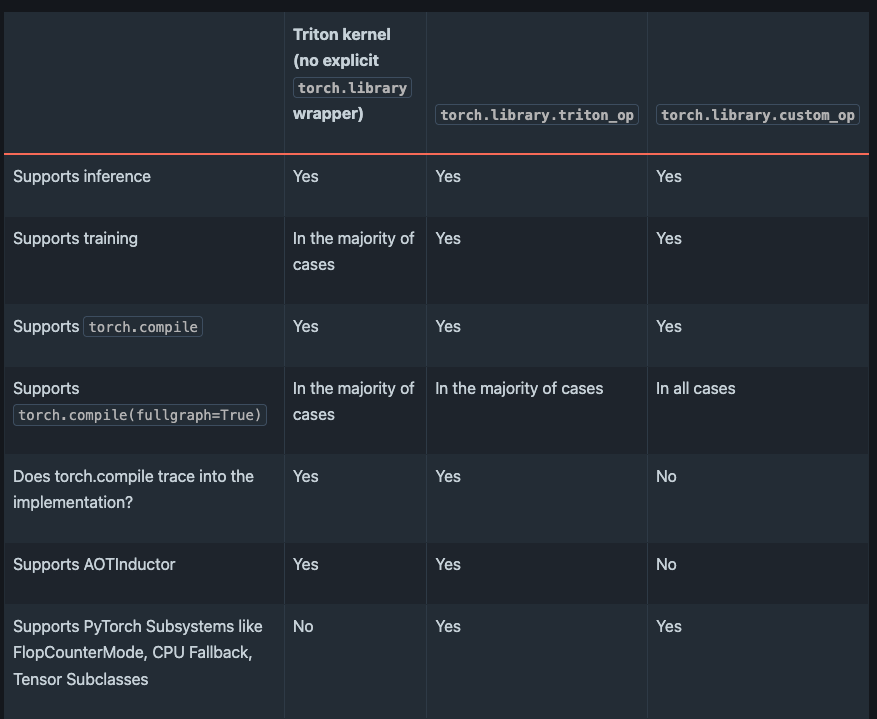

Wrapping Triton kernels with `triton_op`
\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^\^

Use `torch.library.triton_op` to wrap a function that may invoke one or
more Triton kernels. Use `torch.library.wrap_triton` to wrap the calls
to the Triton kernel.


In [4]:
from torch.library import triton_op, wrap_triton

@triton_op("mylib::mysin", mutates_args={})
def mysin(x: torch.Tensor) -> torch.Tensor:
    out = torch.empty_like(x)
    n_elements = x.numel()
    wrap_triton(sin_kernel)[(n_elements,)](x, out, n_elements, BLOCK_SIZE=4)
    return out

@triton.jit
def sin_kernel(
    in_ptr0,
    out_ptr,
    n_elements,
    BLOCK_SIZE: "tl.constexpr",
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(in_ptr0 + offsets, mask=mask)
    output = tl.sin(x)
    tl.store(out_ptr + offsets, output, mask=mask)

You can invoke the `triton_op` in one of the following two ways.


In [5]:
x = torch.randn(3, device="cuda")
y = mysin(x)
z = torch.ops.mylib.mysin.default(x)

assert torch.allclose(y, x.sin())
assert torch.allclose(z, x.sin())

The resulting `triton_op` works with `torch.compile` and `AOTInductor`.


In [6]:
y = torch.compile(mysin)(x)
assert torch.allclose(y, x.sin())

Adding training support
=======================

Use `register_autograd` to add an autograd formula for the `triton_op`.
Prefer this to using `torch.autograd.Function` (which has various
composability footguns with `torch.compile`).


In [7]:
def backward(ctx, grad):
    x, = ctx.saved_tensors
    return grad * x.cos()

def setup_context(ctx, inputs, output):
    x, = inputs
    ctx.save_for_backward(x)

mysin.register_autograd(backward, setup_context=setup_context)

Note that the backward must be a composition of PyTorch-understood
operators. If you want the backward to call Triton kernels, then those
must be wrapped in `triton_op` as well:


In [8]:
@triton.jit
def cos_kernel(
    in_ptr0,
    out_ptr,
    n_elements,
    BLOCK_SIZE: "tl.constexpr",
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(in_ptr0 + offsets, mask=mask)
    output = tl.cos(x)
    tl.store(out_ptr + offsets, output, mask=mask)

@triton_op("mylib::mycos", mutates_args={})
def mycos(x: torch.Tensor) -> torch.Tensor:
    out = torch.empty_like(x)
    n_elements = x.numel()
    wrap_triton(cos_kernel)[(n_elements,)](x, out, n_elements, BLOCK_SIZE=4)
    return out

def backward(ctx, grad):
    x, = ctx.saved_tensors
    return grad * mycos(x)

def setup_context(ctx, inputs, output):
    x, = inputs
    ctx.save_for_backward(x)

mysin.register_autograd(backward, setup_context=setup_context)

Adding a CPU Fallback
=====================

Triton kernels don't run on CPU. Use `register_kernel` to add a CPU (or
any other device) fallback for the `triton_op`:


In [9]:
@mysin.register_kernel("cpu")
def _(x):
    return torch.sin(x)

x = torch.randn(3)
y = mysin(x)
assert torch.allclose(y, x.sin())

The fallback must be composed of PyTorch operators.


Adding a FlopCounter Formula
============================

To specify how many flops the triton kernel reports under PyTorch\'s
flop counter, use `register_flop_formula`.


In [10]:
from torch.utils.flop_counter import FlopCounterMode, register_flop_formula

@register_flop_formula(torch.ops.mylib.mysin)
def _(x_shape):
    numel = 1
    for s in x_shape:
        numel *= s
    return numel

x = torch.randn(3, device="cuda")

`FlopCounterMode` requires
[tabulate](https://pypi.org/project/tabulate/). Before running the code
below, make sure you have `tabulate` installed or install by running
`pip install tabulate`.

\>\>\> with FlopCounterMode() as flop\_counter: \>\>\> y = mysin(x)


Limitations
===========

As of PyTorch 2.3, the support for user-defined Triton kernels in
`torch.compile` includes dynamic shapes, `torch.autograd.Function`, JIT
inductor, and AOT inductor. You can use these features together to build
complex, high-performance models.

PyTorch 2.6 added `torch.library.triton_op`, which adds support for
user-defined Triton kernels in tensor subclasses and other advanced
features.

However, there are certain limitations to be aware of:

-   **Triton Features:** While `triton.heuristics` can be used either
    standalone or before `triton.autotune`, it cannot be used after
    `triton.autotune`. This implies that if `triton.heuristics` and
    `triton.autotune` are to be used together, `triton.heuristics` must
    be used first.

Conclusion
==========

In this recipe, we explored how to utilize user-defined Triton kernels
with `torch.compile`. We delved into the basic usage of a simple vector
addition kernel and advanced usage involving Triton\'s autotune feature.
We also discussed the composability of user-defined Triton kernels with
other PyTorch features and highlighted some current limitations.

See Also
========

-   [Compiling the
    Optimizers](https://pytorch.org/tutorials/recipes/compiling_optimizer.html)
-   [Implementing High-Performance Transformers with Scaled Dot Product
    Attention](https://pytorch.org/tutorials/intermediate/scaled_dot_product_attention_tutorial.html)
